# Big Data Analysis Project - Statistical Inferences

### This is a course project for Concordia's Bigdata class (SOEN691 UU) by Dr. Tristan Glatard in Winter 2020.
*Team Members:*
- Le, Manh Quoc Dat (Student ID: 40153127)<br />
- Tran, Trong Tuan (Student ID: 40151694)<br />
- Phan, Vu Hong Hai (Student ID: 40154023)<br />
- Zhang, Yefei (Student ID: 40153319)<br />

Main project repository: https://github.com/HongHaiPV/concordia-bigdata-project <br />
Datasource: https://sites.google.com/eng.ucsd.edu/fitrec-project/home <br />
>Jianmo Ni, Larry Muhlstein, and Julian McAuley. 2019. Modeling Heart Rate and Activity Data for Personalized Fitness Recommendation. In Proceedings of the 2019 World Wide Web Conference (WWW’19), May 13–17, 2019, San
Francisco, CA, USA. ACM, New York, NY, USA, 11 pages. https://doi.org/10.1145/3308558.3313643
<br />

*The purpose of statistical inferences section is to infers some properties of the data set, finding correlations between columns/features <br />
For initial data exploration phase, please go to this section: [Exploratory Analysis](https://github.com/HongHaiPV/concordia-bigdata-project/blob/master/BigData_Project_Explore.ipynb) <br />
For prediction model training, please go to this section: [Prediction Model](https://github.com/HongHaiPV/concordia-bigdata-project/blob/master/ML_model.ipynb)*

## Preparation - Project framework
We use the same Python version 3.5 as in the course's lab assignments, and the project will also base on PySpark as the main framework to work with the big data set. For the detailed python enviroment and package setup, please follow the guide from the lab: https://github.com/azazel7/BigData-Lab/blob/master/installation_guides/guide.md <br />
We also use Matplotlib as the main package for plotting.

## A. Initialization and brief data set overview

### A.1) Initilization and loading data set into PySpark

First, we will load the post-processed data file `endomondoHR_proper.json` that was already removed abnormal values by the original project.

In [108]:
import os
import sys
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.core.interactiveshell import InteractiveShell
import matplotlib
from pylab import *
import scipy.stats as stats

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 

# Initialize a spark session.

conf = pyspark.SparkConf().setMaster("local[*]")
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("BigData Project - Statistical Inferences") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = './data/endomondoHR_proper.json'
df = spark.read.json(filename_data, mode="DROPMALFORMED")

# Load meta data file into pyspark data frame as well
print('Data frame type: {}'.format(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


Columns of the data set:

In [109]:
print('Columns & datatypes:')
DataFrame(df.dtypes, columns =['Column Name','Data type'])

Columns & datatypes:


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


Look at the overall statistic and first 2 data rows:

In [110]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print('\nFisrt 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,gender,id,sport,url,userId
0,count,167783,167783,167783,167783,167783
1,mean,None,3.614780933983598E8,None,None,4565819.273555724
2,stddev,None,1.571586171633681E8,None,None,3906676.555400663
3,min,female,257936,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674007977,yoga,https://www.endomondo.com/users/9991401/workou...,15481421



Fisrt 2 data rows:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


### A.2) Overview about data set size and summary

In [111]:
# Summary function
def user_activity_workout_summarize(df):
    user_count = format(df.select('userId').distinct().count(), ',d')
    workout_count = format(df.select('id').distinct().count(), ',d')
    activity_count = str(df.select('sport').distinct().count())
    seqOp = (lambda x,y: x+y)
    sum_temp = df.rdd.map(lambda x: len(x.timestamp)).aggregate(0, seqOp, seqOp)
    total_records_count = format(sum_temp, ',d')
    columns=['Users count', 'Activity types count','Workouts count', 'Total records count']
    data = [[user_count], [activity_count], [workout_count], [total_records_count]]
    sum_dict = {column: data[i] for i, column in enumerate(columns)}
    sum_df = pd.DataFrame.from_dict(sum_dict)[columns]
    gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
    gender_activities_count = df.groupBy('gender').count().toPandas()
    gender_user_activity_count = gender_user_count.join(
        gender_activities_count.set_index('gender'), on='gender'
        , how='inner', lsuffix='_gu'
    )
    gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
    
    return sum_df, gender_user_activity_count

sum_dfs = user_activity_workout_summarize(df)
print('\nOverall data set summary on users, activities(workouts) and number of fitness records:')
sum_dfs[0]
print('\nSummarize on genders:')
sum_dfs[1]


Overall data set summary on users, activities(workouts) and number of fitness records:


,Users count,Activity types count,Workouts count,Total records count
0,"1,059",43,"167,783","83,891,500"



Summarize on genders:


,Gender,# of users,Activities (workouts) count
0,unknown,15,1185
1,female,101,9881
2,male,943,156717



## B. Statistical Inferences

### B.1) Heat rate difference between different genders and sports

We take average of heart rate per workout and compare the different between male, female per sport. 

In [112]:
rdd = df.rdd
def avgHeartRate(row):
    if row['heart_rate']!='':
        ht = np.mean(row['heart_rate'])
        return Row(id=int(row['id']), gender=str(row['gender'])
                   , sport=str(row['sport']), userId=row['userId'], avg_heart_rate=float(ht))
print('Top 3 rows of average heart rate per workout:')
rdd_avgHR = rdd.map(avgHeartRate)
rdd_avgHR.toDF().limit(3).toPandas()
print('\nDescribe:')
df1 = spark.createDataFrame(rdd_avgHR)
DataFrame(df1.dtypes, columns =['Column Name','Data type'])

Top 3 rows of average heart rate per workout:


,avg_heart_rate,gender,id,sport,userId
0,152.650,male,396826535,bike,10921915
1,147.710,male,392337038,bike,10921915
2,140.554,male,389643739,bike,10921915



Describe:


,Column Name,Data type
0,avg_heart_rate,double
1,gender,string
2,id,bigint
3,sport,string
4,userId,bigint


In [113]:
df2 = df1.groupBy(['gender','sport']).avg('avg_heart_rate')
df2.createOrReplaceTempView("table1")
df2_Male = spark.sql("SELECT * FROM table1 WHERE gender='male'")
#df2M.toPandas()
df2_Female = spark.sql("SELECT * FROM table1 WHERE gender='female'")
#df2FM.toPandas()

In [114]:
df2A=df2_Male.join(df2_Female, 'sport','outer')
#df2A.toPandas().head(5)

In [115]:
df2_Male = df2_Male.withColumnRenamed('avg(avg_heart_rate)','maleAvgHR')
df2_Female = df2_Female.withColumnRenamed('avg(avg_heart_rate)','femaleAvgHR')
df2AInner = df2_Male.join(df2_Female, 'sport','inner')
df2AInner = df2AInner.withColumn('diffAvg',df2AInner.maleAvgHR-df2AInner.femaleAvgHR)
df2AInner.limit(5).toPandas()

,sport,gender,maleAvgHR,gender,femaleAvgHR,diffAvg
0,weight training,male,107.399738,female,129.021000,-21.621262
1,gymnastics,male,104.550400,female,153.598000,-49.047600
2,mountain bike,male,135.334108,female,142.596029,-7.261921
3,cross-country skiing,male,138.137305,female,135.610060,2.527246
4,hiking,male,110.213909,female,114.032450,-3.818541


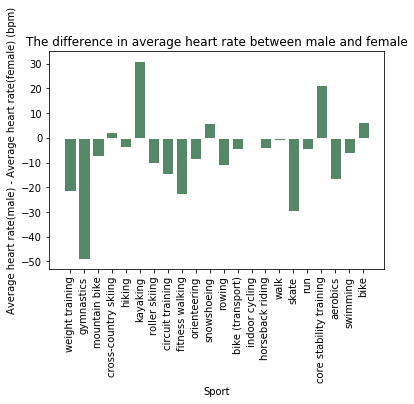

In [116]:
#InteractiveShell.ast_node_interactivity = "none"
rddAInner = df2AInner.rdd
sportType = rddAInner.map(lambda row: row['sport']).collect()
diffAvg = rddAInner.map(lambda row: row['diffAvg']).collect()
xticks = plt.xticks(rotation=90)
xlabel = plt.xlabel('Sport')
ylabel = plt.ylabel('Average heart rate(male) - Average heart rate(female) (bpm)')
plot = plt.bar(sportType, diffAvg, facecolor='#558866', edgecolor='white')
title = plt.title('The difference in average heart rate between male and female')

This plot showed that in most of the sports having both genders participated, average heart rates of female are higher than male's.

### B.2) Correlations of heart rate vs. speed, heart rate vs. altitude

We calculate the Pearson Correlation Coefficients between heart rate vs altitude, heart rate vs speed, the the average of those coefficients by sport and gender, then take the difference of `average_coe(heart rate, altitude)` and `average_coe(heart rate, speed)`. Off course, we only look at workouts with non-empty speed values.

In [117]:
InteractiveShell.ast_node_interactivity = "all"
rdd2 = df.rdd
def covHeartRate(row):
    if row['heart_rate'] != '' and row['speed'] != '' and row['altitude'] != '':   
        if size(row['heart_rate']) == size(row['speed']) and size(row['heart_rate']) == size(row['altitude']):
            pearson_hr_al = stats.pearsonr(row['heart_rate'],row['altitude'])[0]
            pearson_hr_speed = stats.pearsonr(row['heart_rate'],row['speed'])[0] 
            abs_pearson_hr_al = abs(stats.pearsonr(row['heart_rate'],row['altitude'])[0])
            abs_pearson_hr_speed = abs(stats.pearsonr(row['heart_rate'],row['speed'])[0]) 
            return Row(id=int(row['id']), pearson_hr_al=float(pearson_hr_al)
                       , pearson_hr_speed=float(pearson_hr_speed), abs_pearson_hr_al=float(abs_pearson_hr_al)
                       , abs_pearson_hr_speed=float(abs_pearson_hr_speed)
                       , gender=str(row['gender']), sport=str(row['sport']),userId=row['userId'])
rddaHR2 = rdd2.filter(lambda row: row['speed'] is not None).map(covHeartRate)
df5 = spark.createDataFrame(rddaHR2).dropna()
print('\nSummary of coefficients table:')
df5.describe().toPandas()


Summary of coefficients table:


,summary,abs_pearson_hr_al,abs_pearson_hr_speed,gender,id,pearson_hr_al,pearson_hr_speed,sport,userId
0,count,31619,31619,31619,31619,31619,31619,31619,31619
1,mean,0.2740819564531785,0.349513764140059,None,4.0926703876030236E8,0.027003200255308273,0.1896983039418058,None,5246824.048957905
2,stddev,0.197689984651706,0.22459628928652853,None,1.531552854512983E8,0.33686114185183874,0.36962229837024263,None,4202749.049451172
3,min,3.8247149676074963E-16,5.447494646059844E-16,female,9406163,-0.9699399995648301,-0.8858991283273456,bike,2358
4,max,0.9699399995648301,0.9754014117310302,unknown,669263168,0.942730960386833,0.9754014117310302,walk,15326644


In [118]:
# Aggregate by gender & sport
df6 = df5.groupBy(['gender', 'sport']).agg({'abs_pearson_hr_al':'mean', 'abs_pearson_hr_speed':'mean'})
df6.createOrReplaceTempView("table3")
df6M = spark.sql("SELECT * FROM table3 WHERE gender = 'male'")
df6M = df6M.withColumnRenamed('avg(abs_pearson_hr_al)','mAvgPerHtAt') \
    .withColumnRenamed('avg(abs_pearson_hr_speed)','mAvgPerHtSp')
#df6M.toPandas()
df6FM = spark.sql("SELECT * FROM table3 WHERE gender = 'female'")
df6FM = df6FM.withColumnRenamed('avg(abs_pearson_hr_al)','fmAvgPerHtAt') \
    .withColumnRenamed('avg(abs_pearson_hr_speed)','fmAvgPerHtSp')
#df6FM.toPandas()

Average correlation coefficient of different sports for male and female:


,correlation,gender,mean,variance
0,"(heart rate, altitude)",male,0.252697,0.005419
1,"(heart rate, speed)",male,0.355373,0.009346
2,"(heart rate, altitude)",female,0.242045,0.007578
3,"(heart rate, speed)",female,0.219460,0.005855


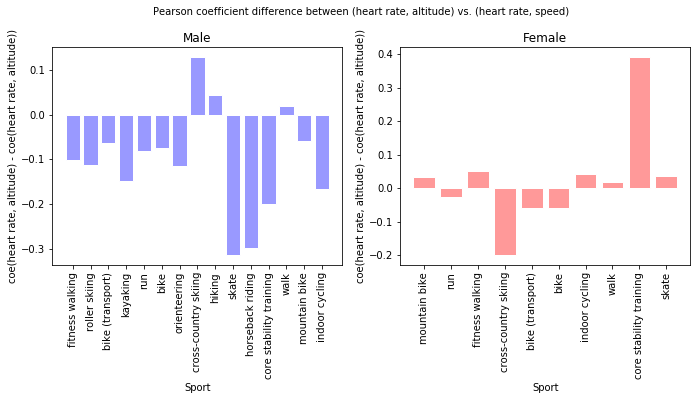

In [119]:
#InteractiveShell.ast_node_interactivity = "none"

rdd6MInner = df6M.rdd
rdd6FMInner = df6FM.rdd
sportTypeM = rdd6MInner.map(lambda row: row['sport']).collect()
sportTypeFM = rdd6FMInner.map(lambda row: row['sport']).collect()
perMhtat = rdd6MInner.map(lambda row: row['mAvgPerHtAt']).collect()
perMhtsp = rdd6MInner.map(lambda row: row['mAvgPerHtSp']).collect()
perFMhtat = rdd6FMInner.map(lambda row: row['fmAvgPerHtAt']).collect()
perFMhtsp = rdd6FMInner.map(lambda row: row['fmAvgPerHtSp']).collect()

meanMhtat, varMhtat = mean(perMhtat), var(perMhtat)
meanMhtsp, varMhtsp = mean(perMhtsp), var(perMhtsp)
meanFMhtat, varFMhtat = mean(perFMhtat), var(perFMhtat)
meanFMhtsp, varFMhtsp = mean(perFMhtsp), var(perFMhtsp)
column_list = [{'gender': 'male', 'correlation': '(heart rate, altitude)'
      , 'mean': float(meanMhtat), 'variance': float(varMhtat)}
     , {'gender': 'male','correlation': '(heart rate, speed)'
        ,'mean': float(meanMhtsp), 'variance': float(varMhtsp) }
     , {'gender': 'female', 'correlation':'(heart rate, altitude)'
      , 'mean': float(meanFMhtat), 'variance': float(varFMhtat)}
        , {'gender':'female', 'correlation':'(heart rate, speed)'
           , 'mean': float(meanFMhtsp), 'variance': float(varFMhtsp)}]
showdf6 = pd.DataFrame(column_list)
print("Average correlation coefficient of different sports for male and female:")
showdf6

# Take the differences
diffMatsp = np.array(perMhtat) - np.array(perMhtsp)
diffFMatsp = np.array(perFMhtat) - np.array(perFMhtsp)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=plt.figaspect(0.35))
xstick_labels0 = axs[0].set_xticklabels(sportTypeM, rotation=90)
xlabel0 = axs[0].set_xlabel('Sport')
ylabel0 = axs[0].set_ylabel(
    'coe(heart rate, altitude) - coe(heart rate, altitude))'
)
title0 = axs[0].set_title('Male')
plot0 = axs[0].bar(sportTypeM, diffMatsp, facecolor='#9999ff', edgecolor='white')
xstick1 = plt.xticks(rotation=90)
xlabel1 = axs[1].set_xlabel('Sport')
ylabel1 = axs[1].set_ylabel('coe(heart rate, altitude) - coe(heart rate, altitude))')
title1 = axs[1].set_title('Female')
plot1 = axs[1].bar(sportTypeFM, diffFMatsp, facecolor='#ff9999', edgecolor='white')
title = fig.text(
    0.5, 1.02, 'Pearson coefficient difference between (heart rate, altitude) vs. (heart rate, speed)'
    , ha='center', va='top', transform=fig.transFigure
)

The 2 charts shows that for both males and females, the average correlation between heart rate and altitude vs heart rate and speed are not so much different.

### B.3) Choice of sports in different periods of a day between male and female
We group the workouts into 4 groups base on started hour and try to see which kinds of sport people prefer at a specific time range of the day.

In [120]:
from datetime import *
from pyspark.sql.types import *
from pyspark.sql.functions import udf

# Apply filter to select workouts that have all records occuring in the sameday (cross out the ones that lasted
# more than one day).
rdd3=df.rdd
def same_day(row):
    if row['heart_rate'] != '' and row['speed'] != '' and row['altitude'] != '':   
        if size(row['heart_rate']) == size(row['speed']) and size(row['heart_rate']) == size(row['altitude']):
            dateValue = [datetime.fromtimestamp(t) - timedelta(hours=7) for t in row['timestamp']]
            return Row(
                id=int(row['id']), gender=row['gender'], timestamp=row['timestamp']
                , heartrate=row['heart_rate'], speed=row['speed'], altitude=row['altitude']
                , year=dateValue[0].year, month=dateValue[0].month, day=dateValue[0].day
                , yearl=dateValue[-1].year, monthl=dateValue[-1].month, dayl=dateValue[-1].day
                , sport=str(row['sport']), userId=row['userId']
            )
#             return Row(ratiohtsp=float(vecsp))
rddaHR3 = rdd3.filter(lambda row: row['speed'] is not None) \
    .map(same_day) \
    .filter(lambda row: row['year'] == row['yearl'] and row['month'] == row['monthl'] and row['day'] == row['dayl'])

df7 = spark.createDataFrame(rddaHR3).drop('year').drop('yearl').drop('month') \
    .drop('day').drop('monthl').drop('dayl')
# DataFrame(df7.dtypes, columns =['Column Name','Data type'])
# df7.describe().toPandas()

# Group and workouts by 4 time ranges of the day based on workout start hour 
# (0: start hour from 0 - 5)
# (1: start hour from 6 - 11)
# (2: start hour from 12 - 17)
# (3: start hour from 18 - 24)
def markWorkout(row):
    hours = [(datetime.fromtimestamp(t) - timedelta(hours=7)).hour for t in row['timestamp']]
    mark = -1
    upIndex = -1
    if hours[0] >= 6 and hours[0] < 12:
        upIndex = [i for i in range(len(hours)) if hours[i] < 12][-1]
        mark = 1
    elif hours[0] >= 12 and hours[0] < 18:
        upIndex=[i for i in range(len(hours)) if hours[i] < 19][-1]
        mark = 2
    elif hours[0] >= 18 and hours[0] < 24:
        upIndex = [i for i in range(len(hours)) if hours[i] < 24][-1]
        mark = 3
    elif hours[0] >= 0 and hours[0] < 6:
        upIndex = [i for i in range(len(hours)) if hours[i] < 8][-1]
        mark = 0
    if mark !=- 1 and upIndex !=- 1:
        reTimestamp = row['timestamp'][:upIndex]
        dateValue = [datetime.fromtimestamp(t) for t in reTimestamp]
        reHeartRate = row['heartrate'][:upIndex]
        reAltitude = row['altitude'][:upIndex]
        reSpeed = row['speed'][:upIndex]
        count = upIndex + 1
        return Row(
            id=row['id'], gender=row['gender'], mark=mark, countTimestamp=count
            , reTimestamp=reTimestamp, dateValue=dateValue, reHeartRate=reHeartRate
            , reAltitude=reAltitude, reSpeed=reSpeed, sport=str(row['sport']), userId=row['userId']
        )
    
rdd31 = df7.rdd.map(markWorkout).filter(lambda row: row['countTimestamp']>10)
df8 = spark.createDataFrame(rdd31)
DataFrame(df8.dtypes, columns=['Column Name','Data type'])
df8.describe().toPandas()
df8.limit(3).toPandas()

,Column Name,Data type
0,countTimestamp,bigint
1,dateValue,array<timestamp>
2,gender,string
3,id,bigint
4,mark,bigint
5,reAltitude,array<double>
6,reHeartRate,array<bigint>
7,reSpeed,array<double>
8,reTimestamp,array<bigint>
9,sport,string


,summary,countTimestamp,gender,id,mark,sport,userId
0,count,29990,29990,29990,29990,29990,29990
1,mean,473.6340780260087,None,4.073903930120707E8,1.4896298766255418,None,5058945.885961987
2,stddev,84.29206626348693,None,1.5412728936162946E8,0.8828901278639227,None,4124350.804949292
3,min,11,female,9406163,0,bike,2358
4,max,500,unknown,669263168,3,walk,15326644


,countTimestamp,dateValue,gender,id,mark,reAltitude,reHeartRate,reSpeed,reTimestamp,sport,userId
0,500,"[2014-08-24 16:45:46, 2014-08-24 16:45:54, 201...",male,396826535,1,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....","[100, 111, 120, 119, 120, 116, 125, 128, 131, ...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...","[1408898746, 1408898754, 1408898765, 140889877...",bike,10921915
1,500,"[2014-08-16 20:41:22, 2014-08-16 20:41:27, 201...",male,392337038,2,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....","[100, 105, 111, 110, 108, 115, 126, 130, 132, ...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...","[1408221682, 1408221687, 1408221699, 140822170...",bike,10921915
2,500,"[2014-08-12 15:47:39, 2014-08-12 15:47:46, 201...",male,389643739,1,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....","[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...","[1407858459, 1407858466, 1407858478, 140785849...",bike,10921915


In [121]:
# Calculate workout count by mark, sport and gender
df8Count = df8.groupBy(['mark','sport','gender']).count().orderBy(['mark','sport','gender'])
rdd8Count = df8Count.rdd
df8Count.createOrReplaceTempView("table4")
df8CountM = spark.sql("SELECT * from table4 where gender='male'")
#df8CountM.toPandas()
df8CountFM = spark.sql("SELECT * from table4 where gender='female'")
#df8CountFM.toPandas()

sportTypeM0 = rdd8Count.filter(
    lambda row: row['mark'] == 0 and row['gender'] == 'male'
).map(lambda row: row['sport']).collect()
sportTypeFM0 = rdd8Count.filter(
    lambda row: row['mark'] == 0 and row['gender'] == 'female'
).map(lambda row: row['sport']).collect()
countM0 = rdd8Count.filter(
    lambda row: row['mark'] == 0 and row['gender'] == 'male'
).map(lambda row: row['count']).collect()
countFM0 = rdd8Count.filter(
    lambda row: row['mark'] == 0 and row['gender'] == 'female'
).map(lambda row: row['count']).collect()

sportTypeM1 = rdd8Count.filter(
    lambda row: row['mark'] == 1 and row['gender'] == 'male'
).map(lambda row: row['sport']).collect()
sportTypeFM1 = rdd8Count.filter(
    lambda row: row['mark'] == 1 and row['gender'] == 'female'
).map(lambda row: row['sport']).collect()
countM1 = rdd8Count.filter(
    lambda row: row['mark'] == 1 and row['gender'] == 'male'
).map(lambda row: row['count']).collect()
countFM1 = rdd8Count.filter(
    lambda row: row['mark'] == 1 and row['gender'] == 'female'
).map(lambda row: row['count']).collect()

sportTypeM2 = rdd8Count.filter(
    lambda row: row['mark'] == 2 and row['gender'] == 'male'
).map(lambda row: row['sport']).collect()
sportTypeFM2 = rdd8Count.filter(
    lambda row: row['mark'] == 2 and row['gender'] == 'female'
).map(lambda row: row['sport']).collect()

countM2 = rdd8Count.filter(
    lambda row: row['mark'] == 2 and row['gender'] == 'male'

).map(lambda row: row['count']).collect()
countFM2 = rdd8Count.filter(
    lambda row: row['mark'] == 2 and row['gender'] == 'female'
).map(lambda row: row['count']).collect()

sportTypeM3 = rdd8Count.filter(
    lambda row: row['mark'] == 3 and row['gender'] == 'male'
).map(lambda row: row['sport']).collect()
sportTypeFM3 = rdd8Count.filter(
    lambda row: row['mark'] == 3 and row['gender'] == 'female'
).map(lambda row: row['sport']).collect()
countM3 = rdd8Count.filter(
    lambda row: row['mark'] == 3 and row['gender'] == 'male'
).map(lambda row: row['count']).collect()
countFM3 = rdd8Count.filter(
    lambda row: row['mark'] == 3 and row['gender'] == 'female'
).map(lambda row: row['count']).collect()

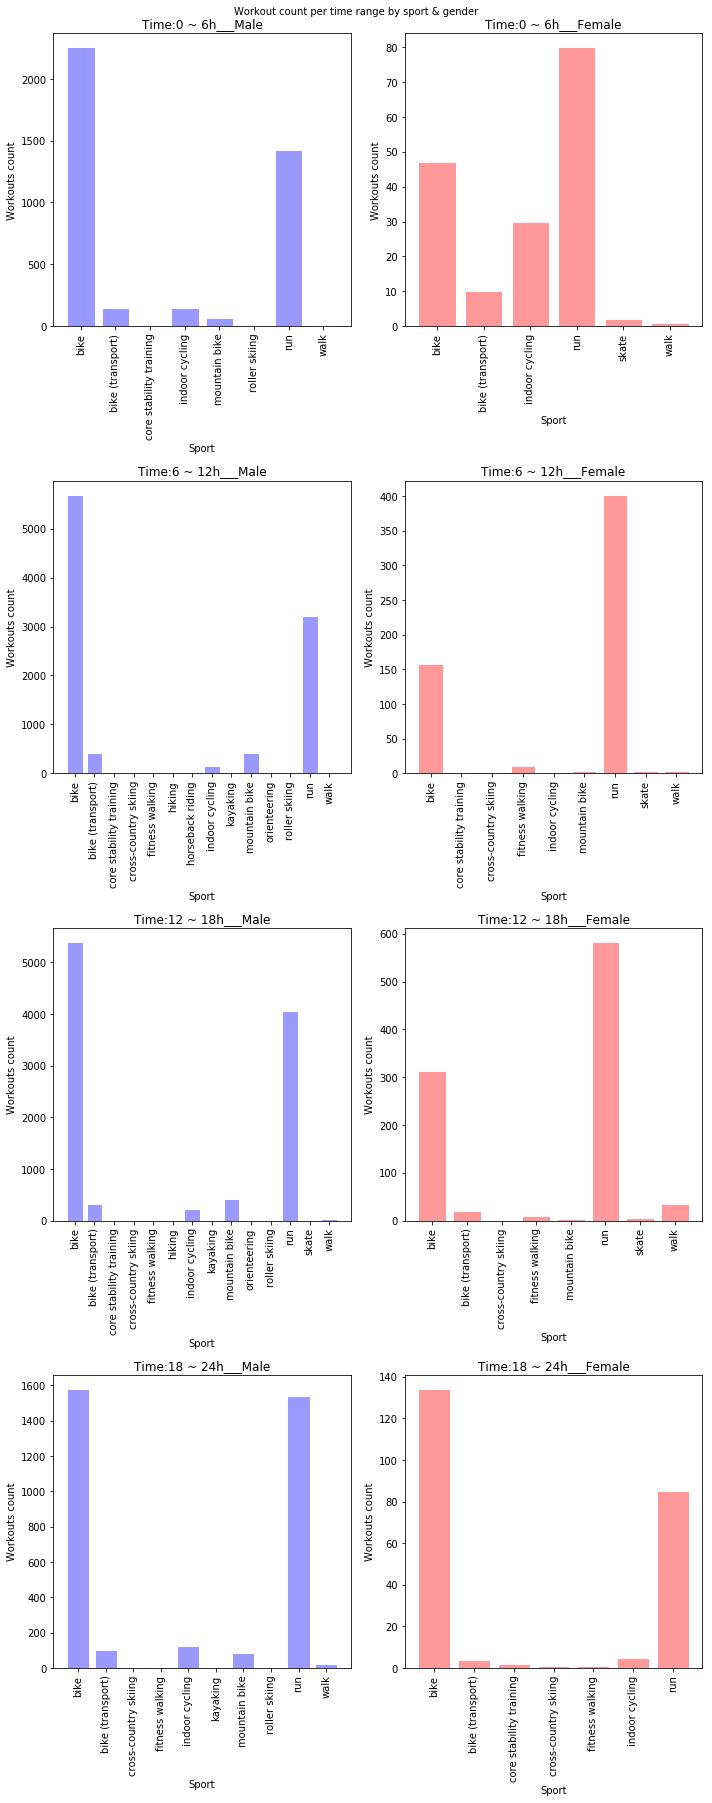

In [122]:
#InteractiveShell.ast_node_interactivity = "none"
fig,axes = plt.subplots(4,2,figsize=(10,25))
subplot_adj = plt.subplots_adjust(wspace=0.3, hspace=0.7)

for i in range(8):
    ax = plt.subplot(4, 2, i+1)
    sca_x = plt.sca(ax)
    xticks = plt.xticks(rotation=90)
    xlabel = plt.xlabel('Sport')
    ylabel = plt.ylabel('Workouts count')
    if i%2 == 0:
        title = plt.title('Time:' + str(int(i / 2 * 6)) + ' ~ ' + str(int(i / 2 * 6) + 6) + 'h___Male')
        sportType = locals()['sportTypeM' + str(int(i / 2))]
        count = locals()['countM' + str(int(i/2))]
        facecolor = '#9999ff'
        plot = bar(sportType, count, facecolor=facecolor, edgecolor='white')
    else:
        title = plt.title(
            'Time:' + str(int((i - 1) / 2 * 6)) + ' ~ ' + str(int((i - 1) / 2 * 6)+ 6) + 'h___Female'
        )
        sportType = locals()['sportTypeFM'+str(int(i/2))]
        count = locals()['countFM'+str(int(i/2))]
        facecolor = '#ff9999'
        plot = bar(sportType, count, facecolor=facecolor, edgecolor='white')
a = fig.tight_layout()
chart_title =fig.text(0.5, 1, 'Workout count per time range by sport & gender', 
            ha='center', va='top', fontsize='medium', transform=fig.transFigure)

From the plots, it can be seen that bike and run are the dominant activities in term of participation, regardless of time of the day and gender. Another observation is that based on the scale of the y-axes, males exercised much more than female in all period of times.

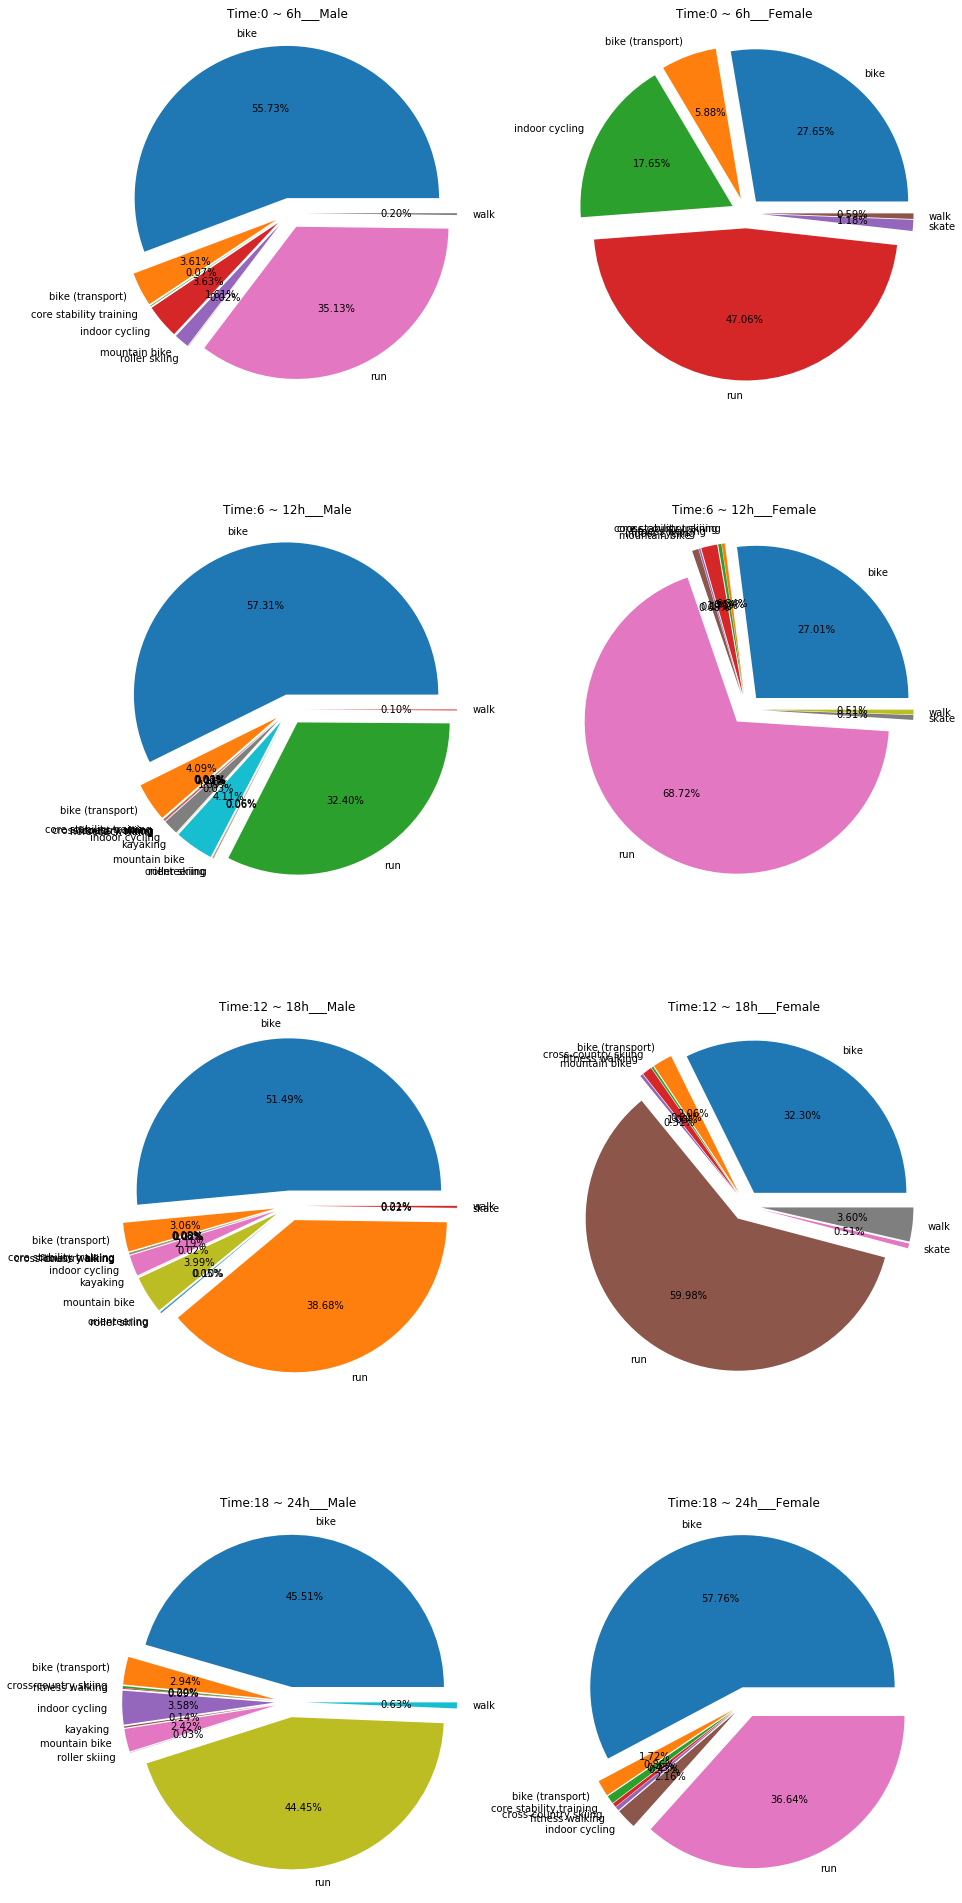

In [123]:
#InteractiveShell.ast_node_interactivity = "none"
fig,axes = plt.subplots(4,2, figsize=(15, 35))


for i in range(8):
    ax = plt.subplot(4, 2 , i + 1)
    plt.sca(ax)
    if i%2 == 0:
        subplot_title = plt.title('Time:' + str(int(i/2*6)) + ' ~ ' + str(int(i/2 * 6) + 6) + 'h___Male ')
        sportType = locals()['sportTypeM' + str(int(i/2))]
        count = locals()['countM' + str(int(i/2))]
        explode = tuple([0.1 for i in range(len(sportType))])
        
        facecolor = '#9999ff'
        plot = plt.pie(x=count, autopct='%.2f%%'#, shadow=True
                       , labels=sportType, explode=explode)
    else:
        subplot_title = plt.title('Time:' + str(int((i-1)/2*6)) + ' ~ ' + str(int((i-1)/2*6) + 6) +'h___Female ')
        sportType = locals()['sportTypeFM' + str(int(i/2))]
        count = locals()['countFM'+str(int(i/2))]
        explode = tuple([0.1 for i in range(len(sportType))])
        
        facecolor = '#ff9999'
        plot = plt.pie(x=count, labels=sportType#, shadow=True
                       , autopct='%.2f%%', explode=explode)


Once again, the percentage in the pie charts show the dorminance of bike and run compared to other sport. This analysis is quite similar to one in the Exploratory Notebook, just in a different view angle. 

### B.4) Average heartrate, altitude, speed change for each sport during different periods of the day

In [124]:
InteractiveShell.ast_node_interactivity = "all"
rdd8 = df8.rdd
def avgReHeartRate(row):
    if row['reHeartRate'] != '':
        reAvgHeartRate = np.mean(row['reHeartRate'])
        reVarHeartRate = np.var(row['reHeartRate'])
        reAvgAltitude = np.mean(row['reAltitude'])
        reVarAltitude = np.var(row['reAltitude'])
        reAvgSpeed = np.mean(row['reSpeed'])
        reVarSpeed = np.var(row['reSpeed'])
        return Row(
            id = int(row['id'])
            , mark = row['mark']
            , gender = str(row['gender'])
            , sport = str(row['sport'])
            , userId = int(row['userId'])
            , reAvgHeartRate = float(reAvgHeartRate)
            , reVarHeartRate = float(reVarHeartRate)
            , reAvgAltitude = float(reAvgAltitude)
            , reVarAltitude = float(reVarAltitude)
            , reAvgSpeed = float(reAvgSpeed)
            , reVarSpeed = float(reVarSpeed)
        )
   
rdda8HR = rdd8.map(avgReHeartRate)
# rdda8HR.take(3)
df9 = spark.createDataFrame(rdda8HR)
DataFrame(df9.dtypes, columns = ['Column Name','Data type'])


df9AvgHearRate=df9.groupBy(['mark','sport','gender']) \
    .avg(
        'reAvgHeartRate', 'reVarHeartRate'
        , 'reAvgAltitude', 'reVarAltitude'
        , 'reAvgSpeed', 'reVarSpeed'
    ).orderBy(['mark','sport','gender'])

df9AvgHearRate.limit(5).toPandas()

,Column Name,Data type
0,gender,string
1,id,bigint
2,mark,bigint
3,reAvgAltitude,double
4,reAvgHeartRate,double
5,reAvgSpeed,double
6,reVarAltitude,double
7,reVarHeartRate,double
8,reVarSpeed,double
9,sport,string


,mark,sport,gender,avg(reAvgHeartRate),avg(reVarHeartRate),avg(reAvgAltitude),avg(reVarAltitude),avg(reAvgSpeed),avg(reVarSpeed)
0,0,bike,female,129.832090,224.531491,93.315891,7859.075411,23.147343,35.628096
1,0,bike,male,134.077341,201.068524,87.976069,4494.765171,27.262490,52.353619
2,0,bike,unknown,151.183768,235.559935,61.315271,289.183458,28.319961,66.067892
3,0,bike (transport),female,126.825651,148.665033,22.427856,147.158613,21.848661,27.695563
4,0,bike (transport),male,125.422155,159.955036,47.599399,284.013813,24.884000,38.040640


In [125]:
#InteractiveShell.ast_node_interactivity = "all"
rdd9AvgHearRate = df9AvgHearRate.rdd
rddtimeM0 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 0 and row['gender'] == 'male')
rddtimeM1 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 1 and row['gender'] == 'male')
rddtimeM2 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 2 and row['gender'] == 'male')
rddtimeM3 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 3 and row['gender'] == 'male')
rddtimeFM0 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 0 and row['gender'] == 'female')
rddtimeFM1 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 1 and row['gender'] == 'female')
rddtimeFM2 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 2 and row['gender'] == 'female')
rddtimeFM3 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 3 and row['gender'] == 'female')

dftimeM0 = spark.createDataFrame(rddtimeM0) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'MreAvgSptAvgHeartRate0') \
    .withColumnRenamed('avg(reVarHeartRate)', 'MreAvgSptVarHeartRate0') \
    .withColumnRenamed('avg(reAvgAltitude)', 'MreAvgSptAvgAltitude0') \
    .withColumnRenamed('avg(reVarAltitude)', 'MreAvgSptVarAltitude0') \
    .withColumnRenamed('avg(reAvgSpeed)', 'MreAvgSptAvgSpeed0') \
    .withColumnRenamed('avg(reVarSpeed)', 'MreAvgSptVarSpeed0')
    
dftimeM1 = spark.createDataFrame(rddtimeM1) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'MreAvgSptAvgHeartRate1') \
    .withColumnRenamed('avg(reVarHeartRate)', 'MreAvgSptVarHeartRate1') \
    .withColumnRenamed('avg(reAvgAltitude)', 'MreAvgSptAvgAltitude1') \
    .withColumnRenamed('avg(reVarAltitude)', 'MreAvgSptVarAltitude1') \
    .withColumnRenamed('avg(reAvgSpeed)', 'MreAvgSptAvgSpeed1') \
    .withColumnRenamed('avg(reVarSpeed)', 'MreAvgSptVarSpeed1')

dftimeM2 = spark.createDataFrame(rddtimeM2) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'MreAvgSptAvgHeartRate2') \
    .withColumnRenamed('avg(reVarHeartRate)', 'MreAvgSptVarHeartRate2') \
    .withColumnRenamed('avg(reAvgAltitude)', 'MreAvgSptAvgAltitude2') \
    .withColumnRenamed('avg(reVarAltitude)', 'MreAvgSptVarAltitude2') \
    .withColumnRenamed('avg(reAvgSpeed)', 'MreAvgSptAvgSpeed2') \
    .withColumnRenamed('avg(reVarSpeed)', 'MreAvgSptVarSpeed2')

dftimeM3 = spark.createDataFrame(rddtimeM3) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'MreAvgSptAvgHeartRate3') \
    .withColumnRenamed('avg(reVarHeartRate)', 'MreAvgSptVarHeartRate3') \
    .withColumnRenamed('avg(reAvgAltitude)', 'MreAvgSptAvgAltitude3') \
    .withColumnRenamed('avg(reVarAltitude)', 'MreAvgSptVarAltitude3') \
    .withColumnRenamed('avg(reAvgSpeed)', 'MreAvgSptAvgSpeed3') \
    .withColumnRenamed('avg(reVarSpeed)', 'MreAvgSptVarSpeed3')

dftimeFM0 = spark.createDataFrame(rddtimeFM0) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'FMreAvgSptAvgHeartRate0') \
    .withColumnRenamed('avg(reVarHeartRate)', 'FMreAvgSptVarHeartRate0') \
    .withColumnRenamed('avg(reAvgAltitude)', 'FMreAvgSptAvgAltitude0') \
    .withColumnRenamed('avg(reVarAltitude)', 'FMreAvgSptVarAltitude0') \
    .withColumnRenamed('avg(reAvgSpeed)', 'FMreAvgSptAvgSpeed0') \
    .withColumnRenamed('avg(reVarSpeed)','FMreAvgSptVarSpeed0')

dftimeFM1 = spark.createDataFrame(rddtimeFM1) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'FMreAvgSptAvgHeartRate1') \
    .withColumnRenamed('avg(reVarHeartRate)', 'FMreAvgSptVarHeartRate1') \
    .withColumnRenamed('avg(reAvgAltitude)', 'FMreAvgSptAvgAltitude1') \
    .withColumnRenamed('avg(reVarAltitude)', 'FMreAvgSptVarAltitude1') \
    .withColumnRenamed('avg(reAvgSpeed)', 'FMreAvgSptAvgSpeed1') \
    .withColumnRenamed('avg(reVarSpeed)', 'FMreAvgSptVarSpeed1')

dftimeFM2 = spark.createDataFrame(rddtimeFM2) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'FMreAvgSptAvgHeartRate2') \
    .withColumnRenamed('avg(reVarHeartRate)', 'FMreAvgSptVarHeartRate2') \
    .withColumnRenamed('avg(reAvgAltitude)', 'FMreAvgSptAvgAltitude2') \
    .withColumnRenamed('avg(reVarAltitude)', 'FMreAvgSptVarAltitude2') \
    .withColumnRenamed('avg(reAvgSpeed)', 'FMreAvgSptAvgSpeed2') \
    .withColumnRenamed('avg(reVarSpeed)', 'FMreAvgSptVarSpeed2')

dftimeFM3 = spark.createDataFrame(rddtimeFM3) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'FMreAvgSptAvgHeartRate3') \
    .withColumnRenamed('avg(reVarHeartRate)', 'FMreAvgSptVarHeartRate3') \
    .withColumnRenamed('avg(reAvgAltitude)', 'FMreAvgSptAvgAltitude3') \
    .withColumnRenamed('avg(reVarAltitude)', 'FMreAvgSptVarAltitude3') \
    .withColumnRenamed('avg(reAvgSpeed)', 'FMreAvgSptAvgSpeed3') \
    .withColumnRenamed('avg(reVarSpeed)', 'FMreAvgSptVarSpeed3')

dftimeMAll = dftimeM0.join(dftimeM1, 'sport', 'outer') \
    .join(dftimeM2, 'sport', 'outer') \
    .join(dftimeM3, 'sport', 'outer')
dftimeMAll.limit(3).toPandas()
dftimeFMAll = dftimeFM0.join(dftimeFM1, 'sport', 'outer') \
    .join(dftimeFM2, 'sport', 'outer').join(dftimeFM3, 'sport', 'outer')
dftimeFMAll.limit(3).toPandas()

,sport,mark,gender,MreAvgSptAvgHeartRate0,MreAvgSptVarHeartRate0,MreAvgSptAvgAltitude0,MreAvgSptVarAltitude0,MreAvgSptAvgSpeed0,MreAvgSptVarSpeed0,mark,...,MreAvgSptAvgSpeed2,MreAvgSptVarSpeed2,mark,gender,MreAvgSptAvgHeartRate3,MreAvgSptVarHeartRate3,MreAvgSptAvgAltitude3,MreAvgSptVarAltitude3,MreAvgSptAvgSpeed3,MreAvgSptVarSpeed3
0,mountain bike,0.0,male,135.362735,257.909719,285.9906,3278.984201,20.862902,60.261503,1,...,20.435741,58.443574,3.0,male,137.145076,273.727046,179.288448,1511.740088,19.881874,52.109524
1,cross-country skiing,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1,...,14.397626,6.466821,3.0,male,150.457486,174.375206,133.967192,109.939131,14.389349,19.953691
2,hiking,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1,...,6.677491,3.819036,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


,sport,mark,gender,FMreAvgSptAvgHeartRate0,FMreAvgSptVarHeartRate0,FMreAvgSptAvgAltitude0,FMreAvgSptVarAltitude0,FMreAvgSptAvgSpeed0,FMreAvgSptVarSpeed0,mark,...,FMreAvgSptAvgSpeed2,FMreAvgSptVarSpeed2,mark,gender,FMreAvgSptAvgHeartRate3,FMreAvgSptVarHeartRate3,FMreAvgSptAvgAltitude3,FMreAvgSptVarAltitude3,FMreAvgSptAvgSpeed3,FMreAvgSptVarSpeed3
0,mountain bike,None,None,None,None,None,None,None,None,1,...,16.344144,39.564655,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,cross-country skiing,None,None,None,None,None,None,None,None,1,...,14.415630,66.590846,3.0,female,130.953908,155.158196,395.993587,748.632263,10.655509,38.614658
2,fitness walking,None,None,None,None,None,None,None,None,1,...,7.180014,1.978819,3.0,female,126.747495,188.104578,20.341483,532.015494,7.361358,2.129999


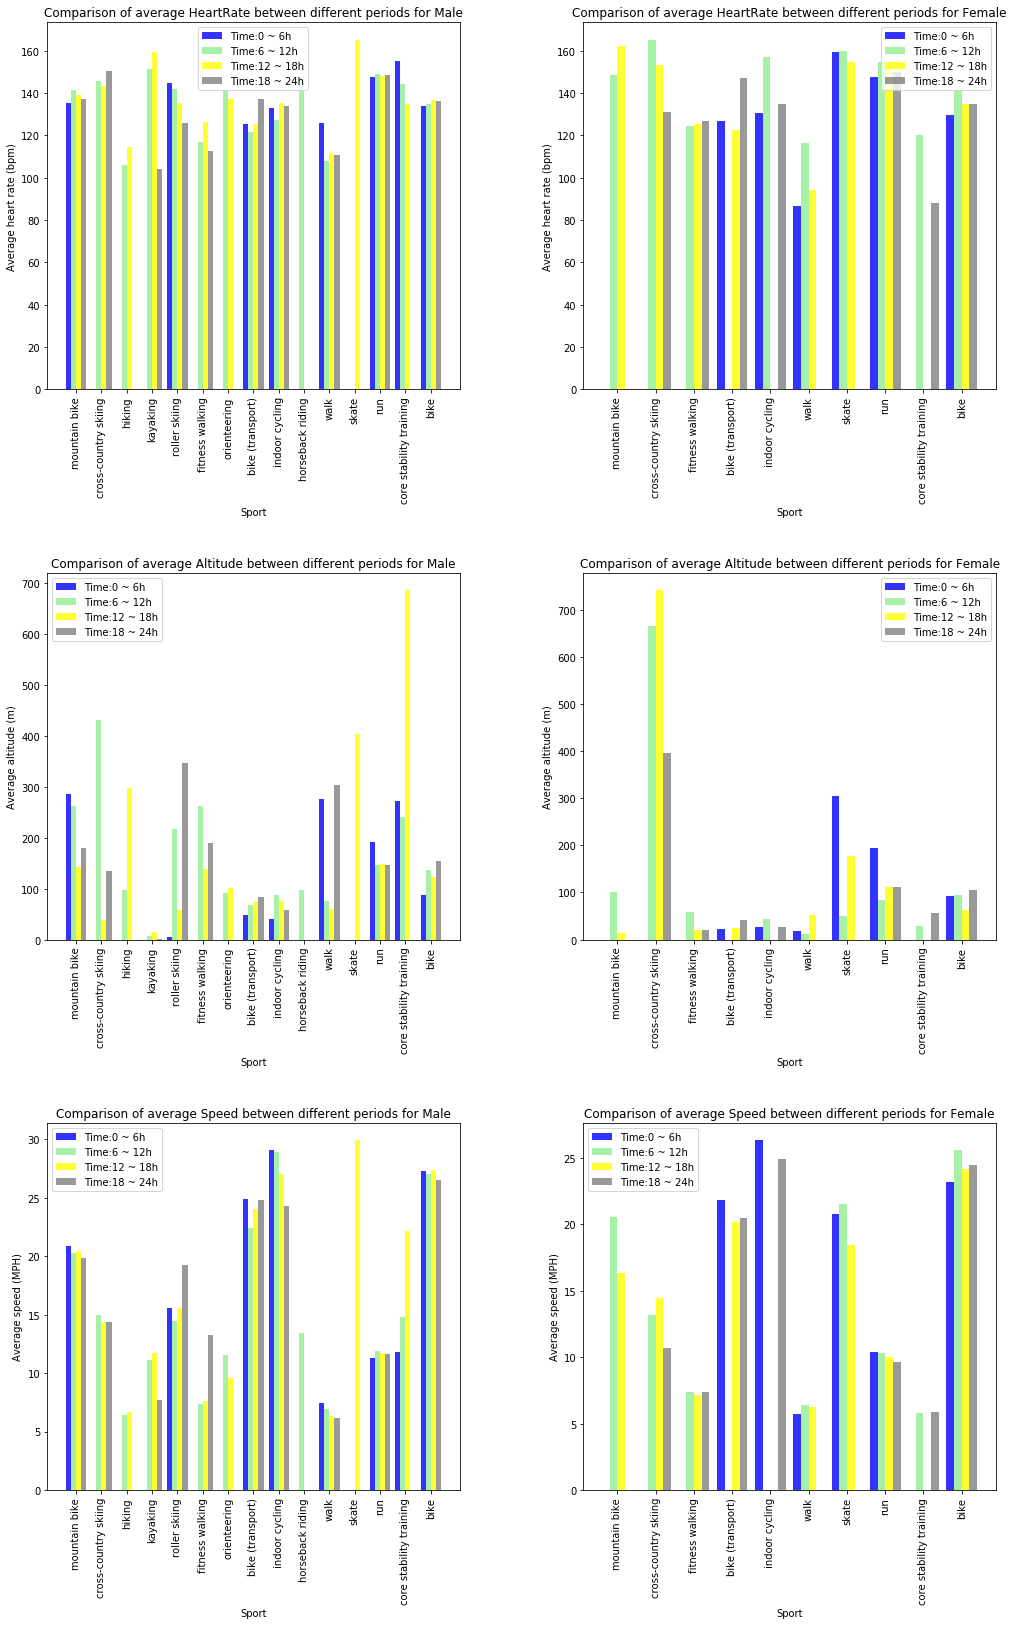

In [126]:
# InteractiveShell.ast_node_interactivity = "none"

fig, axes = plt.subplots(3, 2, figsize=(17, 27))
plot = plt.subplots_adjust(wspace=0.3, hspace=0.5)

bar_width = 0.2
colors = ['blue', 'lightgreen', 'yellow', 'grey']
        
for j in range(6):
    ax = plt.subplot(3, 2, j+1)
    plt.sca(ax)
    if int(j/2) == 1:
        nameStr1 = 'reAvgSptAvgAltitude'
        nameStr3 = 'Altitude'
        nameStr5 = 'altitude (m)'

    elif int(j/2) == 2:
        nameStr1 = 'reAvgSptAvgSpeed'
        nameStr3 = 'Speed'
        nameStr5 = 'speed (MPH)'

    elif int(j/2) == 0:
        nameStr1 = 'reAvgSptAvgHeartRate'
        nameStr3 = 'HeartRate'
        nameStr5 = 'heart rate (bpm)'        
    if j % 2 == 0:
        nameStr2 = 'M'
        nameStr4 = 'Male'
    else:
        nameStr2 = 'FM'
        nameStr4 = 'Female'
    dftimeAll = locals()['dftime' + nameStr2 + 'All']
    dftimeAllSportType = dftimeAll.rdd.map(lambda row: row['sport']).collect() 
    for k in range(4):
        rowName = nameStr2 + nameStr1 + str(k)
        dfTimeLi = dftimeAll.rdd.map(lambda row: row[rowName]).collect()
        dfTimeLi = [0 if i == None else i for i in dfTimeLi]
        plot = plt.bar(x=np.arange(len(dftimeAllSportType)) + k * bar_width
                , height=dfTimeLi, label='Time:' + str(int(k*6)) + ' ~ ' + str(int(k*6)+6) + 'h'
                , color=colors[k], alpha=0.8, width=bar_width)
    xsticks = plt.xticks(np.arange(len(dftimeAllSportType)) + 1.5 * bar_width
                         , dftimeAllSportType, rotation=90)
    title = plt.title("Comparison of average " + nameStr3 + " between different periods for " + nameStr4)
    legend = plt.legend()
    xlabel = plt.xlabel("Sport")
    ylabel = plt.ylabel("Average " + nameStr5)


For average heart rate, there is no much difference within a sport among different time periods of a day, but the overall difference bewtween sports can be observed.   
Next, find the overall average measurements per time period across all sports:

In [127]:
InteractiveShell.ast_node_interactivity = "all"
dftimeMIN = dftimeM0.join(dftimeM1, 'sport', 'inner') \
    .join(dftimeM2, 'sport', 'inner') \
    .join(dftimeM3, 'sport', 'inner')
dftimeMIN.toPandas()
dftimeFMIN = dftimeFM0.join(dftimeFM1, 'sport', 'inner') \
    .join(dftimeFM2, 'sport', 'inner') \
    .join(dftimeFM3, 'sport', 'inner')
dftimeFMIN.limit(5).toPandas()

,sport,mark,gender,MreAvgSptAvgHeartRate0,MreAvgSptVarHeartRate0,MreAvgSptAvgAltitude0,MreAvgSptVarAltitude0,MreAvgSptAvgSpeed0,MreAvgSptVarSpeed0,mark,...,MreAvgSptAvgSpeed2,MreAvgSptVarSpeed2,mark,gender,MreAvgSptAvgHeartRate3,MreAvgSptVarHeartRate3,MreAvgSptAvgAltitude3,MreAvgSptVarAltitude3,MreAvgSptAvgSpeed3,MreAvgSptVarSpeed3
0,mountain bike,0,male,135.362735,257.909719,285.990600,3278.984201,20.862902,60.261503,1,...,20.435741,58.443574,3,male,137.145076,273.727046,179.288448,1511.740088,19.881874,52.109524
1,roller skiing,0,male,144.985972,165.152108,5.329860,260.379609,15.600387,10.044531,1,...,15.560672,7.804708,3,male,125.881764,397.639327,347.137876,763.952293,19.236366,48.850261
2,bike (transport),0,male,125.422155,159.955036,47.599399,284.013813,24.884000,38.040640,1,...,24.075333,38.846037,3,male,137.380781,173.664508,84.145000,289.611924,24.796820,40.474183
3,indoor cycling,0,male,133.200633,151.884367,39.925890,59.255880,29.083401,16.682132,1,...,27.027294,35.988762,3,male,134.151739,251.604747,58.041118,127.165079,24.341508,39.784867
4,walk,0,male,125.926353,163.749827,275.037124,120.661421,7.407682,0.954398,1,...,6.308837,1.184913,3,male,110.811897,48.172738,304.359319,121.986090,6.126935,0.762956
5,run,0,male,147.414170,124.946977,191.395618,557.912861,11.255149,2.942531,1,...,11.718914,3.243481,3,male,148.508216,138.568527,145.718736,242.352146,11.593381,3.306925
6,bike,0,male,134.077341,201.068524,87.976069,4494.765171,27.262490,52.353619,1,...,27.407169,57.059022,3,male,136.302605,200.270680,153.387044,564.919188,26.489645,56.466232


,sport,mark,gender,FMreAvgSptAvgHeartRate0,FMreAvgSptVarHeartRate0,FMreAvgSptAvgAltitude0,FMreAvgSptVarAltitude0,FMreAvgSptAvgSpeed0,FMreAvgSptVarSpeed0,mark,...,FMreAvgSptAvgSpeed2,FMreAvgSptVarSpeed2,mark,gender,FMreAvgSptAvgHeartRate3,FMreAvgSptVarHeartRate3,FMreAvgSptAvgAltitude3,FMreAvgSptVarAltitude3,FMreAvgSptAvgSpeed3,FMreAvgSptVarSpeed3
0,run,0,female,147.38234,132.476439,194.756343,337.329635,10.354932,2.850827,1,...,9.978756,2.850296,3,female,150.044300,118.166958,111.685069,140.406953,9.611503,3.176218
1,bike,0,female,129.83209,224.531491,93.315891,7859.075411,23.147343,35.628096,1,...,24.144636,42.429944,3,female,134.655146,253.222144,105.914791,468.600986,24.494206,41.775060


In [128]:
#InteractiveShell.ast_node_interactivity = "none"
MaverageHeartRate = []
MaverageAltitude = []
MaverageSpeed = []
for i in range(4):
    MaverageHeartRate.append(
        mean(dftimeMIN.rdd.map(
            lambda row: row['MreAvgSptAvgHeartRate' + str(i)]).collect()
            )
    )
    
    MaverageAltitude.append(
        mean(dftimeMIN.rdd.map(
            lambda row: row['MreAvgSptAvgAltitude' + str(i)]).collect()
            )
    )
    MaverageSpeed.append(
        mean(dftimeMIN.rdd.map(
            lambda row: row['MreAvgSptAvgSpeed' + str(i)]).collect()))
    
FMaverageHeartRate = []
FMaverageAltitude = []
FMaverageSpeed = []
for i in range(4):
    FMaverageHeartRate.append(
        mean(dftimeFMIN.rdd.map(
            lambda row: row['FMreAvgSptAvgHeartRate' + str(i)]).collect()
            )
    )
    
    FMaverageAltitude.append(
        mean(dftimeFMIN.rdd.map(
            lambda row: row['FMreAvgSptAvgAltitude' + str(i)]).collect()
            )
    )
    FMaverageSpeed.append(mean(dftimeFMIN.rdd.map(lambda row: row['FMreAvgSptAvgSpeed' + str(i)]).collect()))

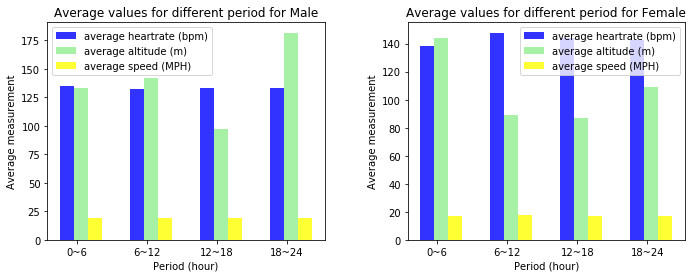

In [129]:
fig,axes = plt.subplots(2, 1,figsize=plt.figaspect(0.35))
subplot_adj = plt.subplots_adjust(wspace =0.3, hspace =0.5)

bar_width = 0.2
colors = ['blue', 'lightgreen', 'yellow']
timesP = ['0~6', '6~12', '12~18', '18~24']

for j in range(2):
    ax = plt.subplot(1, 2, j + 1)
    plotsca = plt.sca(ax)       
    if j % 2 == 0:
        nameStr2 = 'M'
        nameStr4 = 'Male'
    else:
        nameStr2 = 'FM'
        nameStr4 = 'Female'    
    for k in range(3):
        if k == 0:
            nameStr6 = 'averageHeartRate'
            nameStr7 = 'average heartrate (bpm)'
        elif k == 1:
            nameStr6 = 'averageAltitude'
            nameStr7 = 'average altitude (m)'
        elif k == 2:
            nameStr6 = 'averageSpeed'
            nameStr7 = 'average speed (MPH)'
        showY = locals()[nameStr2 + nameStr6]
        plot = plt.bar(
            x=np.arange(len(timesP)) + k * bar_width
            , height=showY, label=nameStr7, color=colors[k]
            , alpha=0.8, width=bar_width
        )
    xsticks = plt.xticks(np.arange(len(timesP))+ 0.7 * bar_width, timesP)
    title = plt.title("Average values for different period for " + nameStr4)
    legend = plt.legend()
    xlabel = plt.xlabel("Period (hour)")
    ylabel = plt.ylabel("Average measurement")

Again, for overall regardless of the sports, average speed and heart rate are not different among time periods.

## C. Classification - Finding similar users
We will apply k-means clustering technique to group similar users, based on users' gender, workout counts per period, sports count, average heart rate, average speed and average altitude per workout.

### C.1) Data preparation

In [132]:
InteractiveShell.ast_node_interactivity = "all"
rdd10 = df.rdd

# same_day function already defined in the previous section.
rddSd10=rdd10.filter(lambda row: row['speed'] is not None).map(same_day) \
    .filter(
    lambda row: row['year'] == row['yearl'] and row['month'] == row['monthl'] and row['day'] == row['dayl'])
dfSd10=spark.createDataFrame(rddSd10) \
    .drop('year').drop('yearl').drop('month').drop('day').drop('monthl').drop('dayl')
# DataFrame(df7.dtypes, columns =['Column Name','Data type'])
# df7.describe().toPandas()
def markWorkout1(row):
    hours = [(datetime.fromtimestamp(t) - timedelta(hours=7)).hour for t in row['timestamp']]
    mark = -1
    upIndex = -1
    if hours[0] >= 6 and hours[0] < 12:
        mark = 1
    elif hours[0] >= 12 and hours[0] < 18:
        mark=2
    elif hours[0] >= 18 and hours[0] < 24:
        mark = 3
    elif hours[0] >= 0 and hours[0] < 6:
        mark = 0
    if mark != -1:
        perAvgHeatRate = mean(np.array(row['heartrate']))
        perAverageAltitude = mean(np.array(row['altitude']))
        perAverageSpeed = mean(np.array(row['speed']))       
        return Row(
            id = row['id'] \
            , sport = str(row['sport']) \
            , userId = row['userId'] \
            , gender = row['gender'] \
            , mark = mark \
            , perAvgHeatRate = float(perAvgHeatRate) \
            , perAverageAltitude = float(perAverageAltitude) \
            , perAverageSpeed = float(perAverageSpeed)
        )

    
rddMAvg10 = dfSd10.rdd.map(markWorkout1)
dfMAvg10 = spark.createDataFrame(rddMAvg10)
print('Data set preparation:')
DataFrame(dfMAvg10.dtypes, columns = ['Column Name','Data type'])
dfMAvg10.describe().toPandas()
dfMAvg10.limit(3).toPandas()

Data set preparation:


,Column Name,Data type
0,gender,string
1,id,bigint
2,mark,bigint
3,perAverageAltitude,double
4,perAverageSpeed,double
5,perAvgHeatRate,double
6,sport,string
7,userId,bigint


,summary,gender,id,mark,perAverageAltitude,perAverageSpeed,perAvgHeatRate,sport,userId
0,count,30045,30045,30045,30045,30045,30045,30045,30045
1,mean,None,4.074134700756532E8,1.4887335663171908,133.03907906140788,20.70152537724081,140.69106160758864,None,5060723.482043602
2,stddev,None,1.5409341564591846E8,0.8823299089191592,269.49326605567506,8.510718358253364,16.28215278063622,None,4124711.9896793677
3,min,female,9406163,0,-442.7876,0.0,58.908,bike,2358
4,max,unknown,669263168,3,7420.6364,74.8578452,199.892,walk,15326644


,gender,id,mark,perAverageAltitude,perAverageSpeed,perAvgHeatRate,sport,userId
0,male,396826535,1,43.0712,26.162158,152.650,bike,10921915
1,male,392337038,2,35.7248,27.218369,147.710,bike,10921915
2,male,389643739,1,62.4256,26.050774,140.554,bike,10921915


In [133]:
print('Aggregate values:')
dftmp=dfMAvg10.groupBy(['userId', 'sport']) \
    .agg({'sport':'count', 'perAverageAltitude':'mean'
            , 'perAverageSpeed':'mean', 'perAvgHeatRate':'mean'})
dftmp.describe().toPandas()
dftmp.limit(3).toPandas()
df10MC=dfMAvg10.groupBy(['userId', 'mark']).count()
df10MC.describe().toPandas()
df10MC.limit(3).toPandas()

Aggregate values:


,summary,userId,sport,avg(perAverageSpeed),avg(perAvgHeatRate),count(sport),avg(perAverageAltitude)
0,count,1255,1255,1255,1255,1255,1255
1,mean,4936423.41434263,None,19.09597551947254,141.86573872006838,23.9402390438247,149.96033156328656
2,stddev,4079524.1311200694,None,8.327942220408842,15.626995400361197,39.60036124567687,275.8006486346371
3,min,2358,bike,0.0,58.908,1,-80.6044
4,max,15326644,walk,74.8578452,185.07600000000002,386,3471.6469000000006


,userId,sport,avg(perAverageSpeed),avg(perAvgHeatRate),count(sport),avg(perAverageAltitude)
0,775277,walk,6.694675,105.268000,1,106.802800
1,1818822,run,10.720204,161.852364,22,53.181473
2,12200275,bike,29.075578,139.095836,366,382.462013


,summary,userId,mark,count
0,count,2040,2040,2040
1,mean,5189895.992156862,1.5196078431372548,14.727941176470589
2,stddev,4149792.639871396,1.002991035992237,23.172488035221683
3,min,2358,0,1
4,max,15326644,3,277


,userId,mark,count
0,1069797,2,6
1,2941284,1,91
2,7967148,3,12


#### Prepare the cordinates for each userId before starting k-mean implementation. 
Users' coordinates (pre-scaling) will be built based on:
- Marks (hour period) count per period by 4 marks (0, 1, 2, 3)
- Gender: 0 (male) or 1 (female)
- Average speed, heart rate, altitude per workout, per sport to create vectors of n sports (dimentions)

In [134]:
InteractiveShell.ast_node_interactivity = "all"
all_marks = [0, 1, 2, 3]
def mark_count(valueN): 
    '''
    valueN: tuple of (mark, count)
    '''
    markL = []
    dic = {}
    for item in valueN:
        markL.append(item[0])
    # Find the list of marks not belong to the current mark list in valueN 
    li = list(set(all_marks).difference(set(markL)))
    
    # Update count for the existed marks, and assign non-existed marks with 0
    for item in valueN:
        dic[item[0]] = item[1]
    for m in li:
        dic[m] = 0    
    dicSt = sorted(dic.items(), key=lambda d:d[0])
    markL = [value for key,value in dicSt]   
    return markL

# Generate the list of counts per hour mark for each userId
rdd10MCTF = df10MC.rdd.map(
    lambda row: (row['userId'], (row['mark'], row['count']))
).groupByKey().mapValues(mark_count) \
    .map(lambda row: Row(userId=row[0], markCt=row[1]))
#print('\n3 users'' coordinates:')
df10MCTF = spark.createDataFrame(rdd10MCTF)
#print('Marks count vectors, take 3:')
#rdd10MCTF.take(3)

all_sports = sorted(
    dfMAvg10[['sport']].distinct().rdd.map(lambda row: row['sport']).collect()
)

# Generate workout count,  average speed, heart rate & altitude vectors for each user
def f1(valueN):
    sportDic = {}
    averageSpeed = {}
    averageHeartRate = {}
    averageAltitude = {}
    
    sportType = []
    for item in valueN:
        sportType.append(item[0])
    li = list(set(all_sports).difference(set(sportType)))
        
    for item in valueN:
        sportDic[item[0]] = item[4]
        averageSpeed[item[0]] = round(item[1])
        averageHeartRate[item[0]] = round(item[2])
        averageAltitude[item[0]] = round(item[3])
    
    for sp in li:
        sportDic[sp] = 0
        averageSpeed[sp] = 0
        averageHeartRate[sp] = 0
        averageAltitude[sp] = 0
    
    sportDicSt=sorted(sportDic.items(), key=lambda d:d[0])
    sportL=[value for key,value in sportDicSt]
    averageSpeedSt=sorted(averageSpeed.items(), key=lambda d:d[0])
    averageSpeedL=[value for key,value in averageSpeedSt]
    averageHeartRateSt=sorted(averageHeartRate.items(), key=lambda d:d[0])
    averageHeartRateL=[value for key,value in averageHeartRateSt]
    averageAltitudeSt=sorted(averageAltitude.items(), key=lambda d:d[0])
    averageAltitudeL=[value for key,value in averageAltitudeSt]
    
    return sportL, averageSpeedL, averageHeartRateL, averageAltitudeL  
    
rdd10AvgTF = dftmp.rdd.map(
    lambda row: (
        row['userId'], (
                        row['sport'], row['avg(perAverageSpeed)']
                        , row['avg(perAvgHeatRate)'], row['avg(perAverageAltitude)']
                        , row['count(sport)']
                        )
                )
).groupByKey().mapValues(f1).map(
                    lambda row: Row(userId=row[0], sportCt=row[1][0], averageSpeed=row[1][1]
                    , averageHeartRate=row[1][2], averageAltitude=row[1][3])
)
#print('Workout count, average speed, altitude & heart rate vectors, take 3:')
#rdd10AvgTF.take(3)
df10AvgTF = spark.createDataFrame(rdd10AvgTF)


rddgender = dfMAvg10[['userId','gender']].distinct().rdd \
    .filter(lambda row: row['gender'] == 'male' or row['gender'] == 'female') \
    .map(
        lambda row: Row(userId = row['userId'], gender = 0) if row['gender'] == 'male' \
        else Row(userId=row['userId'], gender = 1)
    )
dfgender = spark.createDataFrame(rddgender)
df10GMCAvgTF = df10MCTF.join(df10AvgTF, 'userId', 'inner').join(dfgender,'userId', 'inner')
df10GMCAvgTF.describe().toPandas()
print('Final co-ordinate vectors for users, take 3:')
df10GMCAvgTF.limit(3).toPandas()

,summary,userId,gender
0,count,736,736
1,mean,5185296.997282608,0.09239130434782608
2,stddev,4119649.298763243,0.2897744637987635
3,min,2358,0
4,max,15326644,1


Final co-ordinate vectors for users, take 3:


,userId,markCt,averageAltitude,averageHeartRate,averageSpeed,sportCt,gender
0,4133458,"[1, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]",0
1,14320047,"[2, 4, 2, 0]","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
2,2600099,"[31, 21, 68, 2]","[22, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0]","[118, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 142, ...","[27, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0]","[117, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0]",0


#### Features standardization
Since all of the features are at different scales, we need to apply standardization on them before measuring distances by apply scaling factors for all features by max altitude.

In [147]:
def marginM(row):
    maxMarkC = max(row['markCt'])
    maxAverageAltitude = max(row['averageAltitude'])
    maxAverageHeartRate = max(row['averageHeartRate'])
    maxAverageSpeed = max(row['averageSpeed'])
    maxSportC = max(row['sportCt'])
    return Row(
        maxMarkC=maxMarkC, maxAverageAltitude=maxAverageAltitude
        , maxAverageHeartRate=maxAverageHeartRate, maxAverageSpeed=maxAverageSpeed
        , maxSportC=maxSportC
    )  

maxRecord = spark.createDataFrame(
    df10GMCAvgTF.rdd.map(marginM)
).groupBy().max(
    'maxMarkC', 'maxAverageAltitude', 'maxAverageHeartRate', 'maxAverageSpeed', 'maxSportC'
    ).rdd.map(lambda row: (row[0], row[1], row[2], row[3], row[4])).collect()

maxMarkC = maxRecord[0][0]
maxAverageAltitude = maxRecord[0][1]
maxAverageHeartRate = maxRecord[0][2]
maxAverageSpeed = maxRecord[0][3]
maxSportC = maxRecord[0][4]

# Define scaling factors to calculate distance for each feature later
markCM = round(maxAverageAltitude / maxMarkC)
AverageHeartRateM = round(maxAverageAltitude / maxAverageHeartRate)
AverageSpeedM = round(maxAverageAltitude / maxAverageSpeed)
SportCM = round(maxAverageAltitude / maxSportC)
genderM = maxAverageAltitude

### C.2) K-means Implementation
#### - Initialize centroids:
Start initialize central centroids with k = 5. There are some assumptions on different impacts of hour period, altitude, heart rate, speed, workout count and gender so weights are applied.

In [142]:
import random
random.seed(50)
rdd10GMCAvgTF = df10GMCAvgTF.rdd
userId = rdd10GMCAvgTF.map(lambda row: row['userId']).collect()
initUsers = random.sample(userId, 5)
centroids = rdd10GMCAvgTF.filter(lambda row: row['userId'] in initUsers).collect()

#### - Assign users  to their closest centroids:

In [143]:
# Apply different weights for different features
weightMark = 1
weightAltitude = 1
weightHeartRate = 5
weightSpeed = 1.2
weightSport = 1
weightGender = 3

# Function to assign user to the closest centroid the first time
def assigCent(row):
    distDic = {}
    for centroid in centroids:
        # calculate distances:
        disMark = np.sum(
            np.square(np.array(row['markCt']) - np.array(centroid['markCt']))
        )
        disAltitude = np.sum(
            np.square(np.array(row['averageAltitude']) - np.array(centroid['averageAltitude']))
        )
        disHeartRate = np.sum(
            np.square(np.array(row['averageHeartRate']) - np.array(centroid['averageHeartRate']))
        )
        disSpeed = np.sum(
            np.square(np.array(row['averageSpeed']) - np.array(centroid['averageSpeed']))
        )
        disSport = np.sum(
            np.square(np.array(row['sportCt']) - np.array(centroid['sportCt']))
        )
        disGender = np.sum(np.square(np.array(row['gender']) - np.array(centroid['gender'])))
        # Calculate final distances based on weighted value per feature defined above:
        distDic[centroid['userId']] = weightMark * markCM * disMark \
            + weightAltitude * disAltitude \
            + weightHeartRate * AverageHeartRateM * disHeartRate \
            + weightSpeed * AverageSpeedM * disSpeed \
            + weightSport * SportCM * disSport \
            + weightGender * genderM * disGender
        
    selectedCentroid = min(distDic, key = distDic.get)
    return selectedCentroid

assignedGroup = rdd10GMCAvgTF.map(
    lambda row: (assigCent(row), row['userId'])
).groupByKey().mapValues(list).map(lambda row: row[1]).collect()

firstAssignGroup = assignedGroup

def cluster_summarize_df(assignedGroup):
    display_list = []
    for index, centroid in enumerate(assignedGroup):
          display_list.append({'Group': index, 'Users count': len(centroid)})
    display_df = pd.DataFrame(display_list)
    return display_df

print('After initializing centroid:')
cluster_summarize_df(firstAssignGroup)

After initializing centroid:


,Group,Users count
0,0,448
1,1,49
2,2,30
3,3,172
4,4,37


#### - Next iterations

In [144]:
# Function to re-calculate co-ordinates for new centroids
def new_coordinates(bList):
    countSum = []
    for i in range(len(bList)):
        if i == 0:
            countSum = np.array(bList[i])
        else:
            countSum += np.array(bList[i])
    return countSum / len(bList)

# Function to assign users to clusters from second time
def assigLCent(row):
    distDic = {}
    for key, value in centroids.items():
        disMark = np.sum(
            np.square(np.array(row['markCt']) - np.array(value['markCt']))
        )
        disAltitude = np.sum(
            np.square(np.array(row['averageAltitude']) - np.array(value['averageAltitude']))
        )
        disHeartRate = np.sum(
            np.square(np.array(row['averageHeartRate']) - np.array(value['averageHeartRate']))
        )
        disSpeed = np.sum(
            np.square(np.array(row['averageSpeed']) - np.array(value['averageSpeed']))
        )
        disSport = np.sum(
            np.square(np.array(row['sportCt']) - np.array(value['sportCt']))
        )
        disGender = np.sum(
            np.square(np.array(row['gender']) - np.array(value['gender']))
        )
        distDic[key] = weightMark * markCM * disMark \
            + weightAltitude * disAltitude \
            + weightHeartRate * AverageHeartRateM * disHeartRate \
            + weightSpeed * AverageSpeedM * disSpeed \
            + weightSport * SportCM * disSport \
            + weightGender * genderM * disGender
    selectedCentroid = min(distDic, key=distDic.get)
    return selectedCentroid

# Function to compare 2 clusters
def compare(r1, r2):
    if len(r1) != len(r2):
        #print(str(len(r1)) + " - " + str(len(r2)))
        return False
    for i in range(len(r1)):
        list_found = False
        for j in range(len(r2)):
            res_list = r1[i]
            a_list = r2[j]            
            if res_list == a_list:
                list_found = True                  
                break
        if not list_found:
#             print(r2[j])
            return False
    return True   

# Function to sort clusters before comparing
def sortedgroup(groups):
    sortedG = []
    for group in groups:
        sortedG.append(sorted(group))
    return sortedG
        
times = 0
maxIter = 20
compResult = False

# Converge / loop break condition
while compResult == False and times <= maxIter:
    
    newCentroid={}
    i = 0
    # Re-calculate co-ordinates for new centroids
    for group in assignedGroup:
        markList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['markCt']).collect()
        )
        
        altitudeList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['averageAltitude']).collect()
        )
        
        heartRateList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['averageHeartRate']).collect()
        )
        
        speedList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['averageSpeed']).collect()
        )
        sportList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['sportCt']).collect()
        )
        
        genderList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['gender']).collect()
        )
        
        newCentroid[i] = {
            'markCt':markList, 'averageAltitude':altitudeList
            , 'averageHeartRate':heartRateList, 'averageSpeed':speedList
            , 'sportCt':sportList, 'gender':genderList
        }
        
        i += 1

    centroids = newCentroid 
    
    # Assign users to new groups
    newAssignedGroup = rdd10GMCAvgTF.map(
        lambda row: (assigLCent(row), row['userId'])
    ).groupByKey().mapValues(list).map(lambda row: row[1]).collect()
    
    print('\nIteration #{} - Group summary:'.format(times))
    cluster_summarize_df(newAssignedGroup)
    
    # Check if new clusters are the same with the preivous iteration
    compResult = compare(sortedgroup(assignedGroup), sortedgroup(newAssignedGroup))
    
    if compResult == True or times == maxIter:
        print("---------")
        print('Clusters converged after {} iterations'.format(times + 1))
        
    assignedGroup=newAssignedGroup
        
    times+=1

#print(firstAssignGroup)
#print("---------")
#print(assignedGroup)
    


Iteration #0 - Group summary:


,Group,Users count
0,0,426
1,1,53
2,2,24
3,3,178
4,4,55



Iteration #1 - Group summary:


,Group,Users count
0,0,427
1,1,29
2,2,20
3,3,205
4,4,55



Iteration #2 - Group summary:


,Group,Users count
0,0,427
1,1,22
2,2,17
3,3,215
4,4,55



Iteration #3 - Group summary:


,Group,Users count
0,0,425
1,1,21
2,2,18
3,3,217
4,4,55



Iteration #4 - Group summary:


,Group,Users count
0,0,422
1,1,21
2,2,18
3,3,220
4,4,55



Iteration #5 - Group summary:


,Group,Users count
0,0,417
1,1,21
2,2,19
3,3,224
4,4,55



Iteration #6 - Group summary:


,Group,Users count
0,0,413
1,1,22
2,2,18
3,3,228
4,4,55



Iteration #7 - Group summary:


,Group,Users count
0,0,406
1,1,24
2,2,22
3,3,229
4,4,55



Iteration #8 - Group summary:


,Group,Users count
0,0,387
1,1,23
2,2,39
3,3,232
4,4,55



Iteration #9 - Group summary:


,Group,Users count
0,0,261
1,1,22
2,2,165
3,3,233
4,4,55



Iteration #10 - Group summary:


,Group,Users count
0,0,233
1,1,21
2,2,195
3,3,233
4,4,54



Iteration #11 - Group summary:


,Group,Users count
0,0,233
1,1,20
2,2,196
3,3,233
4,4,54



Iteration #12 - Group summary:


,Group,Users count
0,0,233
1,1,19
2,2,197
3,3,233
4,4,54



Iteration #13 - Group summary:


,Group,Users count
0,0,233
1,1,18
2,2,198
3,3,233
4,4,54



Iteration #14 - Group summary:


,Group,Users count
0,0,233
1,1,18
2,2,198
3,3,233
4,4,54


---------
Clusters converged after 15 iterations


### C.3) K-means result:
Prepare data for plotting:

In [145]:
InteractiveShell.ast_node_interactivity = "all"

def reRow(li):
    count = 0
    sumV = 0
    for i in li:
        if i != 0:
            sumV += i
            count += 1
    if count != 0:
        value = sumV / count
        return value
    else:
        return 0        

def countAverage(row):
    avgAltitudeSP = reRow(row['averageAltitude'])
    avgHeartRateSP = reRow(row['averageHeartRate'])
    avgSpeedSP = reRow(row['averageSpeed'])
    return Row(
        useId = row['userId'], markCt = row['markCt']
        , avgAltitudeSP = float(avgAltitudeSP), avgHeartRateSP = float(avgHeartRateSP)
        , avgSpeedSP = float(avgSpeedSP), sportCt = row['sportCt'], gender=row['gender']
    )
    
temprdds = []
for group in firstAssignGroup:
    temprdds.append(
        spark.createDataFrame(
            rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(countAverage)
        )
    )
print('Summary for first assigned clusters:')
for i, temprdd in enumerate(temprdds):
    print('\nGroup #{}:'.format(i))
    temprdd.toPandas().describe()

for group in assignedGroup:
    temprdds.append(
        spark.createDataFrame(
            rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(countAverage)
        )
    )
print('Summary for final clusters:')    
for i, temprdd in enumerate(temprdds[5:]):
    print('\nGroup #{}:'.format(i))
    temprdd.toPandas().describe()



Summary for first assigned clusters:

Group #0:


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,useId
count,448.000000,448.000000,448.000000,448.000000,4.480000e+02
mean,149.528662,140.696652,22.475909,0.058036,5.047102e+06
std,282.774966,12.048079,4.652498,0.234072,4.134821e+06
min,-46.000000,92.000000,10.333333,0.000000,2.358000e+03
25%,30.000000,133.000000,19.250000,0.000000,1.611963e+06
50%,57.000000,141.000000,22.333333,0.000000,3.737545e+06
75%,149.541667,148.500000,26.000000,0.000000,7.729819e+06
max,2591.000000,175.000000,35.000000,1.000000,1.454427e+07



Group #1:


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,useId
count,49.000000,49.000000,49.000000,49.000000,4.900000e+01
mean,269.578231,159.522109,11.120748,0.204082,5.913496e+06
std,244.349493,14.392067,2.751844,0.407206,4.288480e+06
min,11.000000,98.250000,8.000000,0.000000,8.011800e+04
25%,128.000000,156.000000,10.000000,0.000000,2.175400e+06
50%,204.000000,162.000000,11.000000,0.000000,4.905815e+06
75%,338.000000,166.000000,12.000000,0.000000,9.481945e+06
max,1349.000000,185.000000,25.750000,1.000000,1.477965e+07



Group #2:


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,useId
count,30.000000,30.000000,30.000000,30.000000,3.000000e+01
mean,607.100000,144.900000,10.916667,0.066667,6.410728e+06
std,544.202254,9.863202,2.414337,0.253708,4.131458e+06
min,149.000000,121.500000,8.000000,0.000000,7.320080e+05
25%,259.500000,141.250000,9.000000,0.000000,3.500392e+06
50%,374.500000,147.000000,11.000000,0.000000,4.929488e+06
75%,662.500000,149.000000,12.000000,0.000000,8.979736e+06
max,2432.000000,170.000000,17.500000,1.000000,1.437007e+07



Group #3:


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,useId
count,172.000000,172.000000,172.000000,172.000000,1.720000e+02
mean,67.858527,148.416182,11.817829,0.156977,5.041990e+06
std,92.698010,11.806670,3.578338,0.364841,4.011476e+06
min,-3.000000,113.000000,6.000000,0.000000,5.844000e+03
25%,20.916667,141.000000,10.000000,0.000000,1.736130e+06
50%,37.500000,150.000000,11.000000,0.000000,3.998186e+06
75%,78.625000,156.250000,13.000000,0.000000,8.048987e+06
max,576.000000,175.000000,41.000000,1.000000,1.532664e+07



Group #4:


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,useId
count,37.000000,37.000000,37.000000,37.000000,3.700000e+01
mean,90.813063,137.684685,22.173423,0.081081,5.566797e+06
std,91.139891,11.961247,3.830483,0.276725,4.129220e+06
min,0.000000,111.000000,12.500000,0.000000,4.434000e+03
25%,32.500000,133.750000,20.333333,0.000000,2.497422e+06
50%,54.500000,139.000000,22.333333,0.000000,4.496645e+06
75%,129.333333,145.000000,25.000000,0.000000,9.107441e+06
max,391.000000,158.500000,27.500000,1.000000,1.357742e+07


Summary for final clusters:

Group #0:


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,useId
count,233.000000,233.000000,233.000000,233.000000,2.330000e+02
mean,150.765379,139.704578,25.268956,0.047210,5.521073e+06
std,309.520405,12.900179,3.813310,0.212545,4.183529e+06
min,-46.000000,92.000000,15.000000,0.000000,5.844000e+03
25%,29.000000,132.000000,23.000000,0.000000,1.958991e+06
50%,56.000000,140.000000,25.000000,0.000000,4.668578e+06
75%,144.000000,148.000000,28.000000,0.000000,8.280412e+06
max,2591.000000,175.000000,35.000000,1.000000,1.439443e+07



Group #1:


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,useId
count,18.000000,18.000000,18.000000,18.000000,1.800000e+01
mean,309.583333,142.023148,11.962963,0.388889,4.301862e+06
std,272.255108,19.451965,7.743341,0.501631,3.879317e+06
min,6.500000,115.500000,6.000000,0.000000,7.752770e+05
25%,84.500000,124.625000,8.500000,0.000000,1.605940e+06
50%,220.250000,140.375000,9.750000,0.000000,2.833338e+06
75%,549.875000,159.250000,12.458333,1.000000,5.983974e+06
max,942.000000,175.000000,41.000000,1.000000,1.340676e+07



Group #2:


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,useId
count,198.000000,198.000000,198.000000,198.000000,1.980000e+02
mean,156.017340,142.314226,19.188215,0.075758,4.441601e+06
std,261.548691,10.829822,3.202244,0.265281,4.027266e+06
min,-20.000000,96.500000,10.333333,0.000000,2.358000e+03
25%,30.000000,134.500000,17.000000,0.000000,1.125041e+06
50%,62.833333,143.000000,19.500000,0.000000,3.141447e+06
75%,167.250000,149.250000,21.500000,0.000000,7.143598e+06
max,1844.000000,171.500000,28.000000,1.000000,1.454427e+07



Group #3:


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,useId
count,233.000000,233.000000,233.000000,233.000000,2.330000e+02
mean,159.371245,150.653791,11.408441,0.133047,5.618289e+06
std,287.391427,12.220874,2.307409,0.340357,4.106055e+06
min,-3.000000,98.250000,7.000000,0.000000,1.365300e+04
25%,24.000000,142.000000,10.000000,0.000000,2.155614e+06
50%,53.000000,152.000000,11.000000,0.000000,4.433918e+06
75%,166.000000,159.000000,12.000000,0.000000,8.875079e+06
max,2432.000000,185.000000,25.750000,1.000000,1.532664e+07



Group #4:


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,useId
count,54.000000,54.000000,54.000000,54.000000,5.400000e+01
mean,87.354762,137.582716,22.856922,0.074074,4.889570e+06
std,87.124096,12.223112,3.504651,0.264351,4.011735e+06
min,10.250000,108.500000,13.714286,0.000000,4.434000e+03
25%,31.333333,131.464286,20.750000,0.000000,1.708385e+06
50%,47.166667,138.125000,23.366667,0.000000,4.069488e+06
75%,106.750000,146.250000,25.500000,0.000000,7.518628e+06
max,321.666667,163.333333,30.000000,1.000000,1.357742e+07


#### - Plot results for first and final clusters iterations:
We will plot mean measurements of the groups / clusters to plot and compare between first and final iterations. 

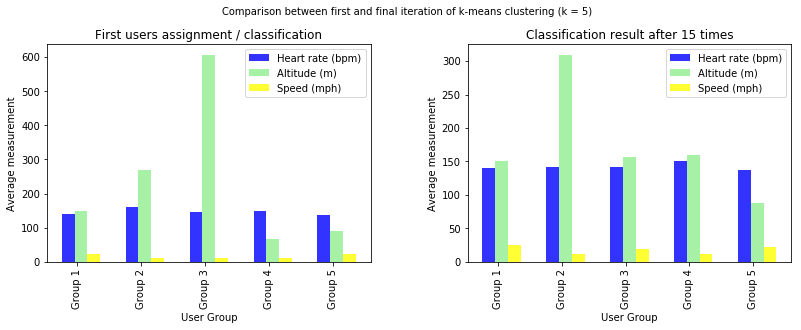

In [146]:
# InteractiveShell.ast_node_interactivity = "none"
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.3))
subplot_adj = plt.subplots_adjust(wspace =0.3, hspace =0.5)

bar_width = 0.2
color = ['blue', 'lightgreen', 'yellow']
xShow = ['Group {}'.format(i+1) for i in range(5)]

avgAltitude = []
avgHeartrate = []
avgSpeed = []
avgAltitude1 = []
avgHeartrate1 = []
avgSpeed1 = []
for i in range(len(temprdds)):
    if i < 5:
        avgAltitude.append(
            np.mean(
                np.array(temprdds[i].rdd.map(lambda row: row['avgAltitudeSP']).collect())
            )
        )
        
        avgHeartrate.append(
            np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgHeartRateSP']).collect())
                   )
        )
        
        avgSpeed.append(
            np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgSpeedSP']).collect())
                   )
        )
    else:
        avgAltitude1.append(
            np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgAltitudeSP']).collect())
                   )
        )
        avgHeartrate1.append(
            np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgHeartRateSP']).collect())
                   )
        )
        avgSpeed1.append(
            np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgSpeedSP']).collect())
                   )
        )
ax = plt.subplot(1,2,1)
sca = plt.sca(ax)    
plot = plt.bar(
    x=np.arange(len(xShow)), height=avgHeartrate
    , label='Heart rate (bpm)', color=color[0], alpha=0.8, width=bar_width
)

plot = plt.bar(
    x=np.arange(len(xShow)) + 1 * bar_width, height=avgAltitude
    , label='Altitude (m)', color=color[1], alpha=0.8, width=bar_width
)
plot = plt.bar(
    x=np.arange(len(xShow)) + 2 * bar_width, height=avgSpeed
    , label='Speed (mph)', color=color[2], alpha=0.8, width=bar_width
)
xsticks = plt.xticks(np.arange(len(xShow)) + 0.7 * bar_width, xShow, rotation=90)
title = plt.title("First users assignment / classification")
legend = plt.legend()
xlabel = plt.xlabel("User Group")
ylabel = plt.ylabel("Average measurement")

ax=plt.subplot(1,2,2)
sca = plt.sca(ax) 
plot = plt.bar(
    x=np.arange(len(xShow)), height=avgHeartrate1
    , label='Heart rate (bpm)', color=color[0], alpha=0.8, width=bar_width
)
plot = plt.bar(
    x=np.arange(len(xShow)) + 1 * bar_width, height=avgAltitude1
    , label='Altitude (m)', color=color[1], alpha=0.8, width=bar_width
)
plot = plt.bar(
    x=np.arange(len(xShow)) + 2 * bar_width, height=avgSpeed1
    , label='Speed (mph)', color=color[2], alpha=0.8, width=bar_width
)
xsticks = plt.xticks(np.arange(len(xShow)) + 0.7 * bar_width, xShow, rotation=90)
title = plt.title("Classification result after {} times".format(times))
legend = plt.legend()
xlabel = plt.xlabel("User Group")
ylabel = plt.ylabel("Average measurement")
fig_title = fig.text(
    0.5, 1.01, 'Comparison between first and final iteration of k-means clustering (k = 5)'
    , ha='center', va='top', transform=fig.transFigure, fontsize='medium'
)

The summary plots on k-means result showed that average heart rate and speed do not differ much among groups, only the obvious difference is average altitude.

That's the end of our statistic inferences phase!   
Next, for model training, please refer to the section: <br />
https://github.com/HongHaiPV/concordia-bigdata-project/blob/master/ML_model.ipynb